This notebook is a summary of our data analysis up to June 16, 2025.

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data cleaning and merging

def parse_gdp_values(df):
    """ Parses monetary values in a pandas dataframe, converting string values with suffixes to floats with corresponding zeros.
        This function modifies the original dataframe.

    Args:
        df (_type_): _description_
    """
    for country in df.index:
        for year in df:
            val = df.loc[country,year]
            if isinstance(val, float):
                continue    
            val = val.strip().upper()
            if val.endswith('K'):
                df.loc[country,year] = float(val[:-1]) * 1e3
            elif val.endswith('M'):
                df.loc[country,year] = float(val[:-1]) * 1e6
            elif val.endswith('B'):
                df.loc[country,year] = float(val[:-1]) * 1e9
            elif val.endswith('TR'):
                df.loc[country,year] = float(val[:-2]) * 1e12
            else:
                df.loc[country,year] = float(val[:-1])


def df_index_inner_join(df1, df2, df3, key1, key2, key3):
    """ combines 3 pandas dataframes with an inner join along the rows

    Args:
        df1 (_type_): _description_
        df2 (_type_): _description_
        df3 (_type_): _description_
        key1 (_type_): _description_
        key2 (_type_): _description_
        key3 (_type_): _description_

    Returns:
        _type_: _description_
    """
    mask_df1 = df1.index.isin(df2.index) & df1.index.isin(df3.index)
    mask_df2 = df2.index.isin(df1.index) & df2.index.isin(df3.index)
    mask_df3 = df3.index.isin(df2.index) & df3.index.isin(df1.index)

    df1_filtered = df1[mask_df1]
    df2_filtered = df2[mask_df2]
    df3_filtered = df3[mask_df3]

    combined_data = pd.concat([df1_filtered, df2_filtered, df3_filtered], axis=0, keys=[key1, key2, key3], join='inner')
    return combined_data

def drop_countries_by_nan(df, threshold):
    """ Removes rows of a country if either Total GDP or GDP Per Capita 
        contain more than the threshold percentage of missing values.
        Returns a new dataframe.
        
    Args:
        df (Pandas dataframe): Expecting dataframe with outer index = []'Total GDP', 'GDP Per Capita', 'Gini Coeff']
                                inner index = [countries]
        threshold (float): a float between zero and one representing the percentage of nans above which the country is dropped.
    """
    assert (df.index.names[0] == 'Metric' and df.index.names[1] == 'Country'), "Unexpeced MultiIndex names. Expecting ['Metric', 'Countries]"
    assert (isinstance(threshold, float) & (0 <= threshold <= 1))

    df_copy = df.copy()
    valid_country_list = df.index.get_level_values('Country').unique().tolist()
    years_list = df.columns.tolist()

    print("********* DROPPING COUNTRIES **********")
    for country in valid_country_list:
        country_slice = df.xs(country, level='Country')
        country_gdp_nan_sum = pd.isna(country_slice.loc['Total GDP'].values).sum()
        country_gdp_percap_nan_sum = pd.isna(country_slice.loc['GDP Per Capita'].values).sum()
        if (country_gdp_nan_sum > len(years_list)*threshold) | (country_gdp_percap_nan_sum > len(years_list)*threshold):
            df_copy = df_copy.drop(country, level='Country')
            print("Dropping", country)
            print("  -  ", country_gdp_nan_sum, "missing values in Total GDP.")
            print("  -  ", country_gdp_percap_nan_sum, "missing values in GDP Per Capita.")
    print("***************************************")
    return df_copy




#################################################################

# User input validation

def check_years(years_list, start_year, end_year):

    start_year = start_year.strip()
    end_year = end_year.strip()

    years_in_list = (start_year in years_list) & (end_year in years_list)
    years_in_order = (int(end_year) > int(start_year))

    if not ((years_in_list) & (years_in_order)):
        raise KeyError("Invalid year range. Years must be in proper range, and start year must come before end year.")
    return

def check_country(country_list, new_country):

    new_country = new_country.strip()

    if not (new_country in country_list):
        raise KeyError("Country not in list. Try again.")
    return


def get_user_input(combined_data):
    """ Gets the user input and checks that the input is a member of the specified data column. 
        Assumes the columns are years, and the rows are MultiIndexed [Metric, Country]

    Args:
        data_multi_index (Pandas DF): Pandas dataframe containing data for user input to be checked against.
        header (string): The header of the column to check for membership against the user input

    Raises:
        KeyError: If user input does not exist in specified header column.

    Returns:
        string: The valid user input value as an upper case string.
    """    
    
    years_list = combined_data.columns.tolist()

    while True:
        print("Enter a time frame to look at. Valid range is:", years_list[0], "to", years_list[-1])
        start_year = input("Start year: ")
        end_year = input("End year: ")
        try:
            check_years(years_list, start_year, end_year)
            break
        except KeyError as err:
            print(err)
            continue
    year_range = [start_year, end_year]        
    

    valid_country_list = combined_data.index.get_level_values('Country').unique().tolist()
    added_country_list = []
    count = 1
    while True:
        print("Enter a country to include in the analysis. Multiple countries may be added.")
        print("Enter 1 for a list of valid countries to enter")
        print("Enter 0 to analyze current list of countries.")
        user_input = input(f"Enter country number {count} : ")
        if user_input == '1':
            print(valid_country_list)
        elif user_input == '0':
            if count == 1:
                print("No countries added. Please add a country.")
                continue
            else:
                break
        try:
            check_country(valid_country_list, user_input)
            added_country_list.append(user_input)
            count += 1
            print(f"Current country list: {added_country_list}")
        except KeyError as err:
            print(err)
            print(f"Current country list: {added_country_list}")

            continue
    
    return (added_country_list, year_range)


def plotter(df, country_list, year_range, metric):
    idx = pd.IndexSlice
    sub_df = df.loc[idx[metric,country_list],idx[year_range[0]:year_range[-1]]]
    sub_df.transpose().plot() 
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.show()


(579, 64)
********* DROPPING COUNTRIES **********
Dropping Afghanistan
  -   40 missing values in Total GDP.
  -   40 missing values in GDP Per Capita.
Dropping Djibouti
  -   53 missing values in Total GDP.
  -   53 missing values in GDP Per Capita.
Dropping Eritrea
  -   44 missing values in Total GDP.
  -   44 missing values in GDP Per Capita.
Dropping Liechtenstein
  -   63 missing values in Total GDP.
  -   63 missing values in GDP Per Capita.
Dropping Montenegro
  -   37 missing values in Total GDP.
  -   37 missing values in GDP Per Capita.
Dropping Palestine
  -   34 missing values in Total GDP.
  -   34 missing values in GDP Per Capita.
Dropping San Marino
  -   38 missing values in Total GDP.
  -   38 missing values in GDP Per Capita.
Dropping Serbia
  -   35 missing values in Total GDP.
  -   35 missing values in GDP Per Capita.
Dropping South Sudan
  -   56 missing values in Total GDP.
  -   56 missing values in GDP Per Capita.
Dropping Yemen
  -   35 missing values in Tota

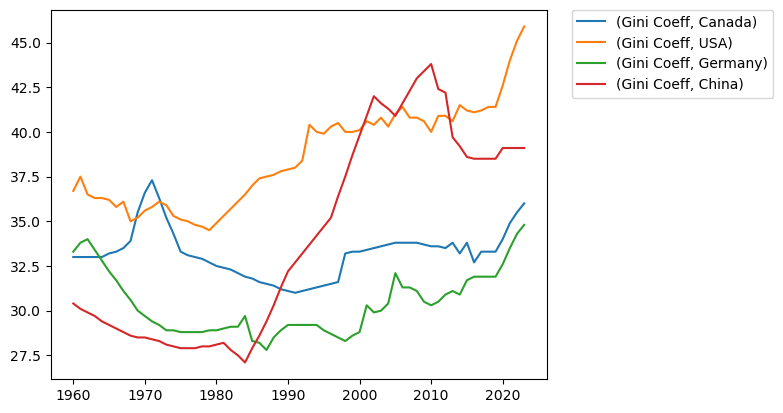

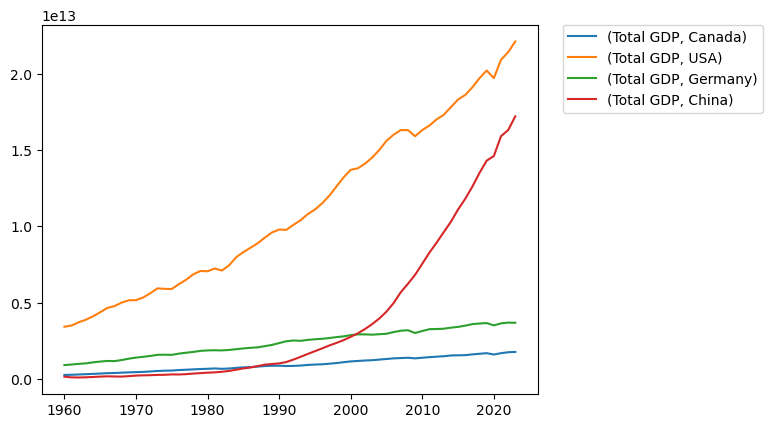

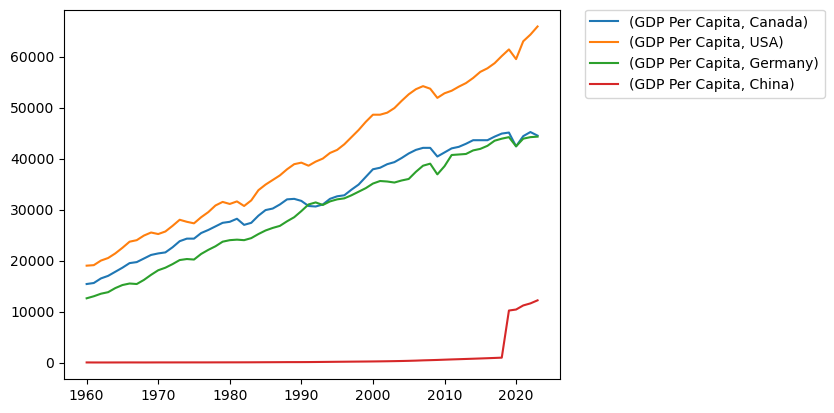

In [7]:
def main():


    # Read in raw data from CSV files
    #   Total GDP, GDP Per Capita, and Gini Coefficient
    total_gdp = pd.read_csv("total_gdp_us_inflation_adjusted.csv")
    gdp_percap = pd.read_csv("gdppercapita_us_inflation_adjusted.csv")
    gini = pd.read_csv("gini.csv")

    
    total_gdp = total_gdp.set_index('country')
    gdp_percap = gdp_percap.set_index('country')
    gini = gini.set_index('country')

    # make copy of original raw data
    total_gdp_copy = total_gdp.copy()
    gdp_percap_copy = gdp_percap.copy()
    gini_copy = gini.copy()
        
    # parse suffixes and convert values from strings to floats
    parse_gdp_values(total_gdp_copy)
    parse_gdp_values(gdp_percap_copy)

    combined_data = df_index_inner_join(total_gdp_copy, gdp_percap_copy, gini_copy, 'Total GDP', 'GDP Per Capita', 'Gini Coeff')
    combined_data.index.names = ['Metric', 'Country']
    print(combined_data.shape)

    data_nans_dropped = drop_countries_by_nan(combined_data, 0.5)
    print(data_nans_dropped.shape)

    user_input = get_user_input(combined_data)
    print(user_input)

    plotter(data_nans_dropped,user_input[0],user_input[1],'Gini Coeff')
    plotter(data_nans_dropped,user_input[0],user_input[1],'Total GDP')
    plotter(data_nans_dropped,user_input[0],user_input[1],'GDP Per Capita')



if __name__ == '__main__':
    
    main()

Add plots here


In [8]:
import matplotlib.pyplot as plt 
#print(combined_data_fixed.head())
# countries = ['South Korea','Brazil','Mexico','South Africa','Poland','India','Taiwan']
#country_list = common_countries
# years = ['1960','2023'] 
# def plotter(df, country_list, year_range, metric):
#     idx = pd.IndexSlice
#     sub_df = df.loc[idx[metric,country_list],idx[year_range[0]:year_range[-1]]]
#     sub_df.transpose().plot() 
#     plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
#     plt.show()

# plotter(data_nans_dropped,user_input[0],user_input[1],'Gini Coeff')
# plotter(data_nans_dropped,user_input[0],user_input[1],'Total GDP')
# plotter(data_nans_dropped,user_input[0],user_input[1],'GDP Per Capita')